# 最大流算法
---
> 多种最大流算法 https://blog.csdn.net/x_y_q_/article/details/51999466 我用的是Edmond-Karp算法(EK算法)

## 定义：
**问题描述：** 一个有向无环图G，选取一个源s，一个目的d。每条有向边上有个容量（capacity）。问从原点到目的点的最大流量，以及流量在各条边上的分布  

## 原理：
**边的容量、流量、残量：** 容量：水管有多粗。流量：水管实际流了多少水。残量：容量与流量的差  
**增广路径：** 一条从源流到到终点的，流量大于等于0的路径  
**反向容量、反向边：** 一条边原本的容量为c，当边上的流量为f时，我们额外增加一条虚设的，反向的边，反向边的容量为f。（原本的图是有向无环图。增加了反向边就有环了。但是只有这样才能得到正确结果）  
**残量网络：** 在一个容量网络（或残量网络）上，找到一条从源到目的的增广路径，流量为f。这条增广路径上，每一条边的残量减f，相反边的残量加f。得到的新的网络是新的残量网络  
- - -  
**以一个例子说明原理**  
**注：**下面的解释中，“回边”与“反向边”是同一个意思  
![1初始](./img/1初始.PNG)  
1.初始的网络.初始的残量网络为DAG的容量网络  

![2找到一条增广路径](./img/2找到一条增广路径.PNG)  
2.通过广度优先遍历，我们先找到了一个增广路径0->1->3->5。这个增广路径的流量为1.我们把增广路径上每条边的残量减去流量(减1)。如果我们添加了这条增广路径，由于路径3-5已经满了，我们没法继续选取路径0->2->3->5。但是显然，0->1->4->5和0->2->3->5才是最优解。所以我们需要改进  

![3为增广路径添加反向边](./img/3为增广路径添加反向边.PNG)  
3.**该算法的核心：添加反向边** 。在增广路径上的每条边，添加回边。每条回边的容量+=增广路径的流量  

![4又找到一条增广路径](./img/4又找到一条增广路径.PNG)  
4.添加了回边后，这时我们又可以找到一条增广路径：0->2->3->1->4->5,流量为1。我们也把这条增广路径上每个边(包括上次新添加的回边3-1)残量减流量(减1)，并添加回边(如果已有回边，就更改回边上的残量)。得到上面更新后的残量网络矩阵。  
5.再次搜索时，没有增广网络了，于是结束  
6.结束时，得到的增广路径有：0->1->3->5，0->2->3->1->4->5。可以看到1->3和3->1的流量抵消了，所以1-3之间实际没有流量通过(从残量矩阵也可以看出确实没有流量通过)。  
这就是回边的意义：如果我们找到的增广路径只是局部最优的，添加回边，继续找增广路径，用到回边抵消一部分流量，最终会得到全局最优的最大流量  
  
最终得到的残量网络矩阵，沿对角线划分，左下部分是每条回边的残量，也即最终形成最大流时，原边上的流量（左下部分capacity\[j\]\[i\]==边i->j上的流量）。右上角矩阵是原边上的残量  
**注：**最大流量是唯一的，但是最大流量下，流量在各条边上的分布情况可能不是唯一的  

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import numpy as np
from queue import Queue

In [2]:
#随机生成一个有向无环图
def random_dag(v_num=10, e_num=20,direction=True,rand_weight=False,max_weight=10):
    G = nx.Graph()
    if direction:
        G=G.to_directed()
    G.add_nodes_from(range(v_num))
    edges = []
    for i in range(e_num):
        f = randint(0,v_num-2)
        t = randint(f+1,v_num-1)
        G.add_edge(f,t, capacity=randint(1,max_weight) if rand_weight else 1) 
        #nx的最大流算法需要边有一个名叫capacity的域，否则一条边的容量将被作为无穷大
    return G

In [3]:
#c语言中，适合用矩阵实现此算法

#随机生成一个有向无环图
def random_dag(v_num=10, e_num=20,direction=True,rand_weight=False,max_weight=10):
    G = nx.Graph()
    if direction:
        G=G.to_directed()
    G.add_nodes_from(range(v_num))
    for i in range(e_num):
        f = randint(0,v_num-2)
        t = randint(f+1,v_num-1)
        G.add_edge(f,t, capacity=randint(1,max_weight) if rand_weight else 1) 
        #nx的最大流算法需要边有一个名叫capacity的域，否则一条边的容量将被作为无穷大
    return G

#生成一个图的节点、边的信息，debug用
def Graph_info(G):
    info = {}
    info['node']=list(G.node)
    info['edges'] = []
    for i,j in G.edges:
        info['edges'].append((i,j,G[i][j]['capacity']))
    return info

#由Graph_info(G)生成的信息创建一个图
def Graph_from_info(info,direction=True):
    G = nx.DiGraph() if direction else nx.Graph()
    G.add_nodes_from(info['node'])
    for i,j,w in info['edges']:
        G.add_edge(i,j,capacity=w)
    return G

In [4]:
INF = 10000 #无穷大
#广度优先搜索
def BFS(G,s,d,pre,capacity):
    visited = [False]*G.number_of_nodes() #标记一个节点是否被访问了
    queue = Queue() #广度优先搜索需要用队列完成.每次运行广度优先搜索前必须先清空队列，否则之前的元素会遗留在队列里
    flow = [0]*G.number_of_nodes() #flow[i]:在残余网络上，从源走到当前节点i时流量可以走多大
    
    flow[s] = INF #源节点流量设为无穷大
    visited[s] = True
    queue.put(s)
    while not queue.empty():
        v = queue.get()
        #for son in G.successors(v):  #这种写法是错误的，因为这样只能找到原来就存在的边，无法找到后来添加进来的边（实际并没有者的添加边，而是增加了一个反向的capacity）,于是无法形成退流
        for son in range(G.number_of_nodes()):  #这种遍历后继节点方法才是正确的
            if not visited[son] and capacity[v][son]>0:  #如果一开始就没有边，则capacity为0
                flow[son]=min(capacity[v][son],flow[v])
                visited[son]=True
                pre[son] = v  #pre[son]:在遍历时son的父节点
                queue.put(son)
                if son == d:  #遍历到了终点，返回当前流量。
                    return flow[son]
    return 0  #如果队列空了还没有遍历到终点，就会到达这里。说明终点不可达，此时增广流量为0，之后也不会再有增广路径了
        
#最大流算法
def max_flow_EK(G,s,d):
    max_flow = 0
    capacity = np.zeros([G.number_of_nodes(),G.number_of_nodes()],dtype=np.int32)
    for f,t in G.edges:
        capacity[f][t] = G[f][t]['capacity']
    
    while True:
        #BFS寻找是否有增广路径
        pre = [-INF]*G.number_of_nodes()
        flow = BFS(G,s,d,pre,capacity)
        max_flow += flow
        if flow==0: #没有增广路径了，结束
            break
        
        #如果有增广路径，通过pre逆着增广路径回溯，在增广路径上每条边都添加一个反向边
        t = G.number_of_nodes()-1    
        while True:
            f = pre[t]
            if f<0 :
                break
            capacity[f][t] -= flow
            capacity[t][f] += flow
            t = f
    
    #最大流计算完了，再用过capacity得到每条边上的flow:
    flow_result = {}
    for v in range(G.number_of_nodes()):
        flow_result[v] = {}
        for son in G.successors(v):
            flow_result[v][son] = capacity[son][v]
    return max_flow,flow_result


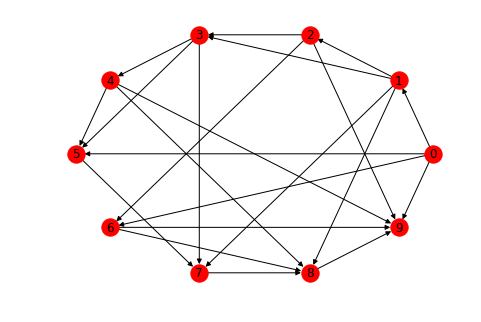

{'node': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'edges': [(0, 1, 8), (0, 5, 8), (0, 9, 3), (0, 6, 10), (1, 8, 4), (1, 3, 1), (1, 7, 8), (1, 2, 8), (2, 9, 2), (2, 3, 6), (2, 6, 3), (3, 5, 6), (3, 7, 2), (3, 4, 10), (4, 5, 5), (4, 8, 2), (4, 9, 3), (5, 7, 6), (6, 9, 8), (6, 8, 2), (7, 8, 2), (8, 9, 8)]}
(23, {0: {1: 8, 5: 2, 9: 3, 6: 10}, 1: {8: 4, 3: 1, 7: 0, 2: 3}, 2: {9: 2, 3: 1, 6: 0}, 3: {5: 0, 7: 0, 4: 2}, 4: {5: 0, 8: 0, 9: 2}, 5: {7: 2}, 6: {9: 8, 8: 2}, 7: {8: 2}, 8: {9: 8}, 9: {}})
(23, {0: {1: 8, 5: 2, 9: 3, 6: 10}, 1: {8: 4, 3: 1, 7: 0, 2: 3}, 2: {9: 2, 3: 1, 6: 0}, 3: {5: 0, 7: 0, 4: 2}, 4: {5: 0, 8: 0, 9: 2}, 5: {7: 2}, 6: {9: 8, 8: 2}, 7: {8: 2}, 8: {9: 8}, 9: {}})


In [5]:
#运行示例
v_num = 10
e_num = 30
G = random_dag(v_num,e_num,direction=True,rand_weight=True)
#G = Graph_from_info(info)
nx.draw_circular(G,with_labels=True,with_width=True)
plt.show()

print(Graph_info(G))
print(nx.maximum_flow(G,_s=0,_t=v_num-1))
print(max_flow_EK(G,0,v_num-1))

In [6]:
#多组数据测试：
v_num=100
e_num=150
error = []
for i in range(1000):
    G = random_dag(v_num,e_num,rand_weight=True,max_weight=100)
    if nx.maximum_flow(G,_s=0,_t=v_num-1)[0]!=max_flow_EK(G,0,v_num-1)[0]:
        error.append(G)
if not error:
    print('success')
else:
    print(error)


success
